## Introduction

This month, the problem proposed by the TPS is fresh and new.

I will try to start an EDA and propose a baseline :-)

*Version history and highlights*

vers 1-4: first attempt at understanding data

vers 5: understanding how the histograms have been configured

vers 6: plotting variable importance of ERT

vers 7: adding variability to distribution of histogram plots

vers 8-9: adding case-wise exploration and feature engineering

vers 10-13: adversarial validation

vers 14: adding decamwers from Ambrosm EDA

vers 15: adding cv validation, voting ensembling and model saving

vers 16-20: experiments with features, number of folds and estimators

In [1]:
# Intel® Extension for Scikit-learn installation:
!pip install scikit-learn-intelex

     |████████████████████████████████| 69 kB 2.4 MB/s             
     |████████████████████████████████| 22.5 MB 6.3 MB/s            
     |████████████████████████████████| 284.3 MB 2.3 kB/s             
     |████████████████████████████████| 4.0 MB 36.3 MB/s            


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from math import factorial
import gc
import joblib

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

Let's first upload the data

In [3]:
train = pd.read_csv("../input/tabular-playground-series-feb-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-feb-2022/test.csv")
sub = pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv")

In [4]:
print("Train shape", train.shape)

Train shape (200000, 288)


## Target exploration

Target analysis is not particularly revealing. Since it is an experiment we have a fairly balanced distribution of targets. 

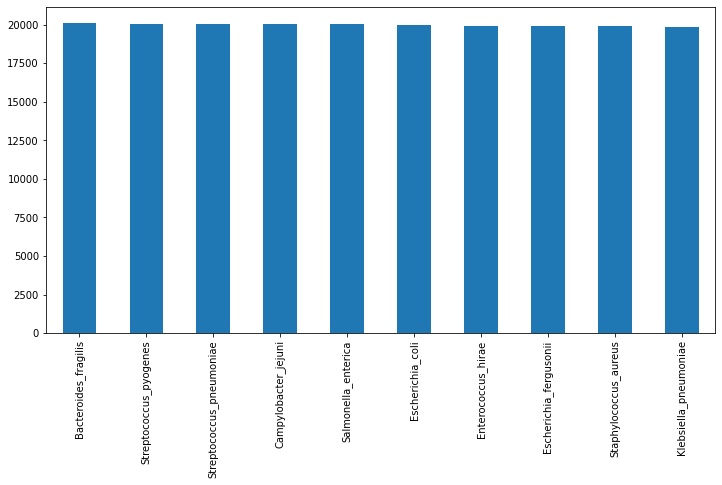

In [5]:
plt.figure(figsize=(12, 6))

train.target.value_counts().plot.bar()

plt.show()

## Feature exploration

Let's turn our attention to features.

Excluding target and the row index, there are 286 histograms. Let's explore better how they are distributed. Each 10-mer has exactly 10 bases (A, T, C, G). Position does not matter for the histogram count (thank you @grayjay for noticing this from the paper).

We first prepare a way to convert the columns into a ATGC distribution.

In [6]:
features = train.columns[1:-1].tolist()

import re

def split_feature(st):
    counts = list(map(int, re.split('A|T|G|C', st)[1:]))
    return counts

feat2counts = {c: split_feature(c) for c in features}

In [7]:
sums = list()
for feat in features:
    xa, xt, xg, xc = feat2counts[feat]
    s = xa+xt+xg+xc
    sums.append(s)
    
print(f"All the histograms sums the bases to: {np.unique(sums)}")

All the histograms sums the bases to: [10]


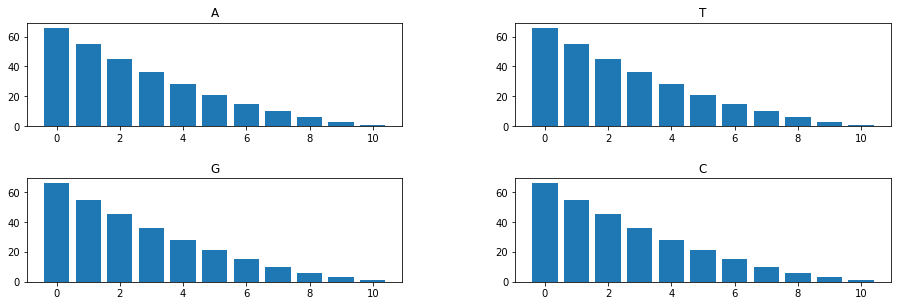

In [8]:
a = [0 for i in range(11)]
t = [0 for i in range(11)]
g = [0 for i in range(11)]
c = [0 for i in range(11)]

for feat in features:
    xa, xt, xg, xc = feat2counts[feat]
    a[xa] += 1
    t[xt] += 1
    g[xt] += 1
    c[xc] += 1
    
plt.figure(figsize=(20, 3))

plt.subplot(2, 2, 1,)
plt.title("A")
plt.bar(range(11), height=a)

plt.subplot(2, 2, 2,)
plt.title("T")
plt.bar(range(11), height=t)

plt.subplot(2, 2, 3,)
plt.title("G")
plt.bar(range(11), height=g)

plt.subplot(2, 2, 4,)
plt.title("C")
plt.bar(range(11), height=c)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=1.3, 
                    wspace=0.3, 
                    hspace=0.5)

plt.show()

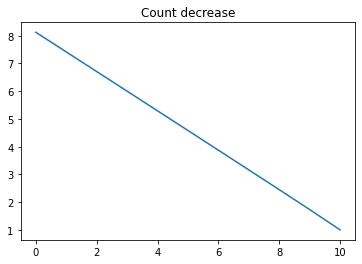

In [9]:
plt.figure(figsize=(6, 4))

plt.plot(np.sqrt(a))
plt.title("Count decrease")

plt.show()

Given the constrain to only have 10 bases, the distribution is equal for all the letters and unbalanced toward lower counts: lower counts are more frequent than higher ones and the decrease fits a squared root transformation.

This opens up to two further questions (that I will try to answer):

* is there a way to represent the space of histograms better than the flat form proposed by the competition that could be exploited by deep learning? (as a sequence or as a graph maybe)

* do we need all the measured histograms? Can't we do with much less?

We can now try to visualize each target what distribution has on the original features. The plot may be not very informative because of the many bars plotted, but similar shapes can hit at possible difficulties since we expect each target to have a distinct shape, partially masked by measurement noise.

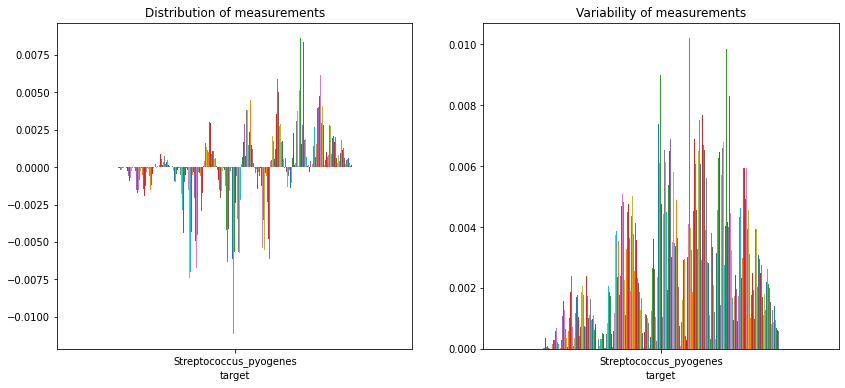

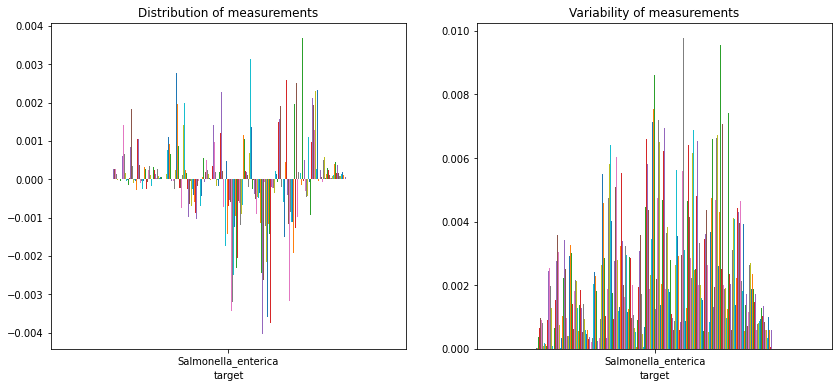

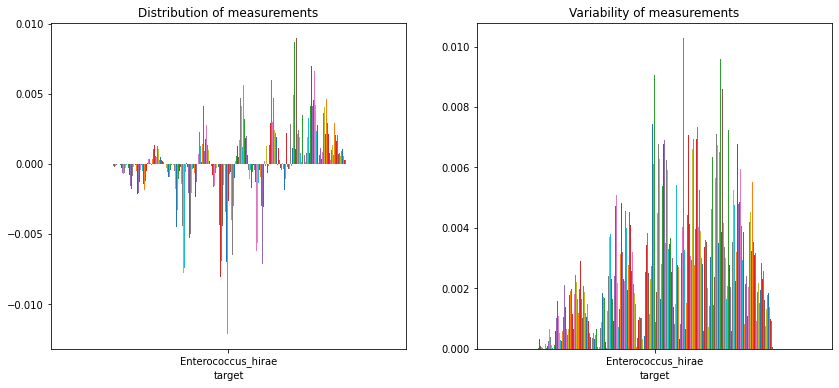

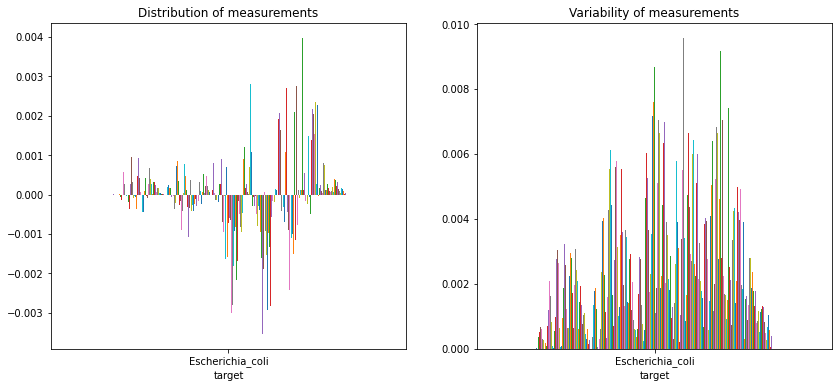

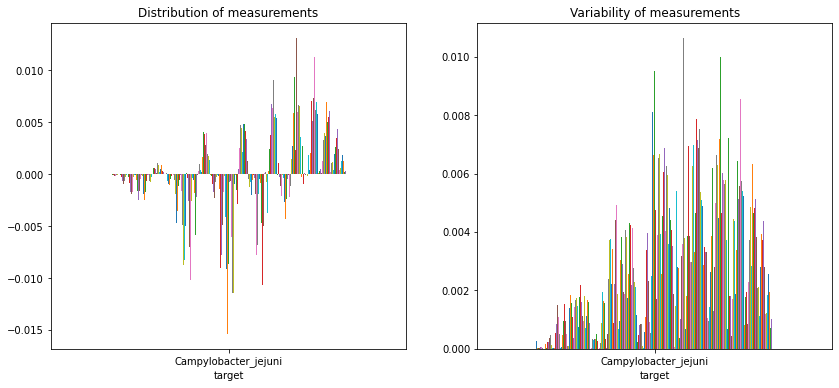

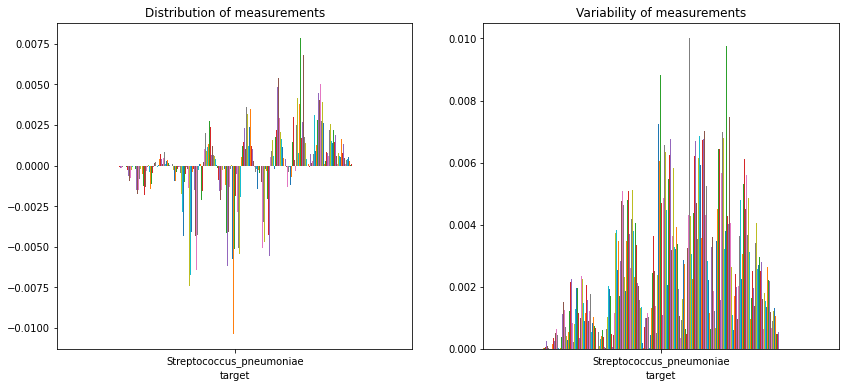

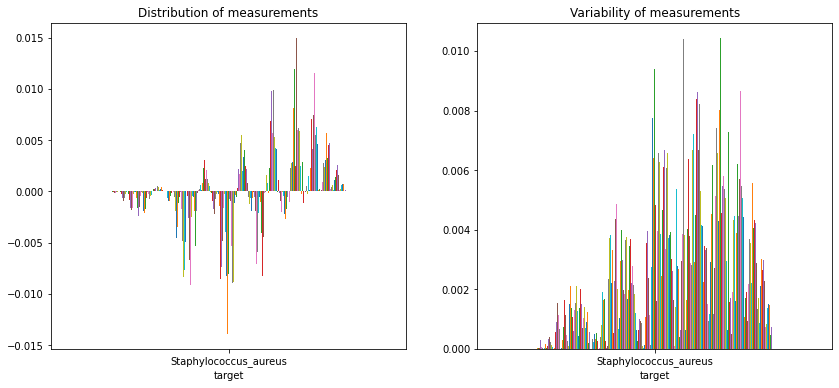

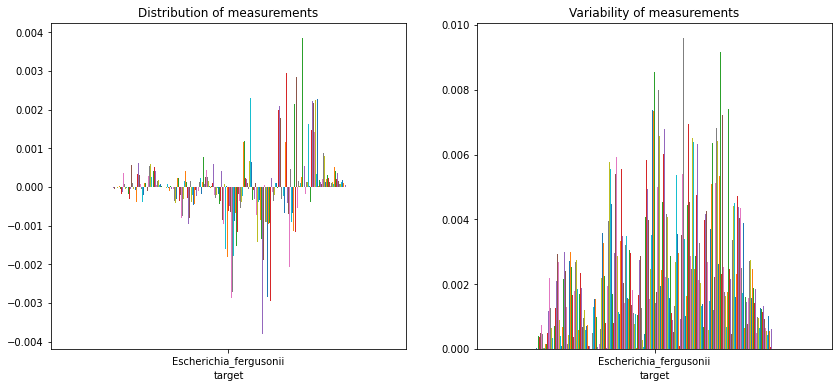

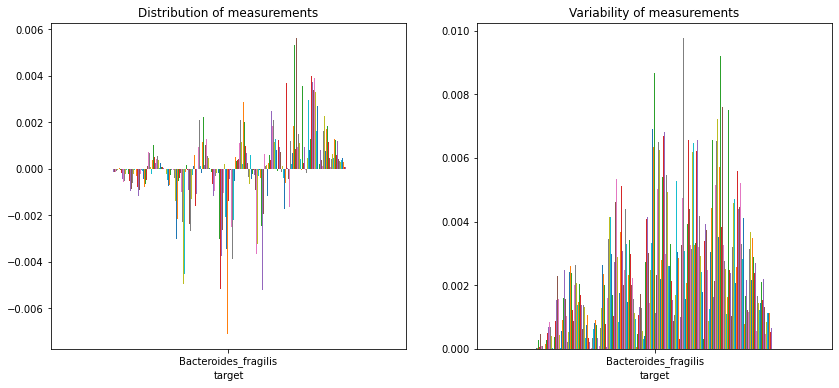

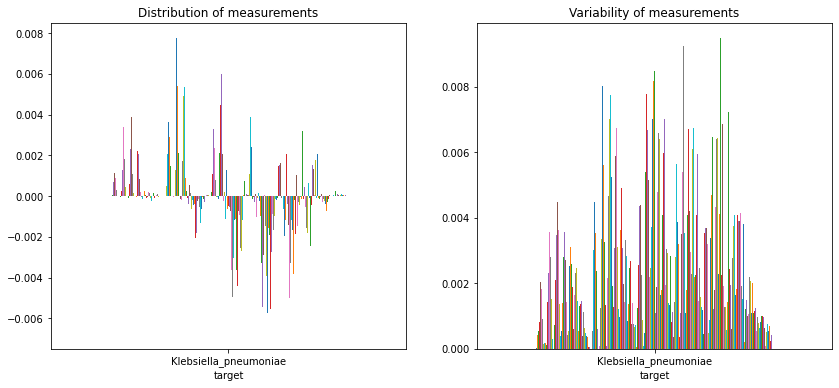

In [10]:
freqs = train.set_index('row_id').groupby('target').mean()
varia = train.set_index('row_id').groupby('target').std()

for target in train.target.unique():
    
    fig = plt.figure(figsize=(14, 6))
    plt.margins(0.015, tight=True)
    
    ax = plt.subplot(1, 2, 1)
    freqs[freqs.index==target].plot.bar(ax=ax, width=1.0)
    _lg = ax.get_legend()
    _lg.remove()

    plt.xticks(rotation = 0)

    plt.title("Distribution of measurements")
    
    ax = plt.subplot(1, 2, 2)
    varia[varia.index==target].plot.bar(ax=ax, width=1.0)
    _lg = ax.get_legend()
    _lg.remove()

    plt.xticks(rotation = 0)

    plt.title("Variability of measurements")


    plt.show()

Each bacteria, seem to have a specific mean profile, but the variability is also quite high.

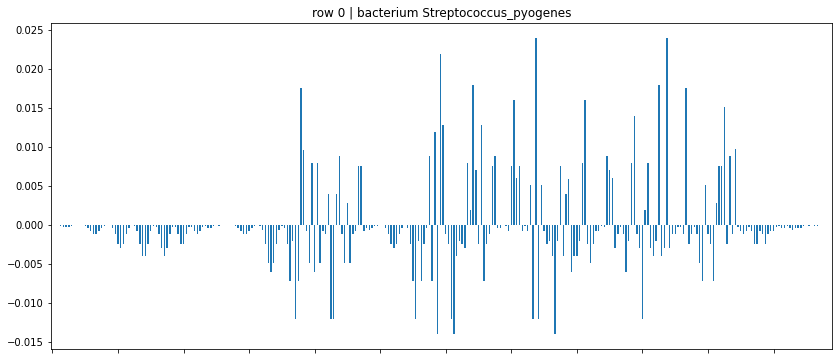

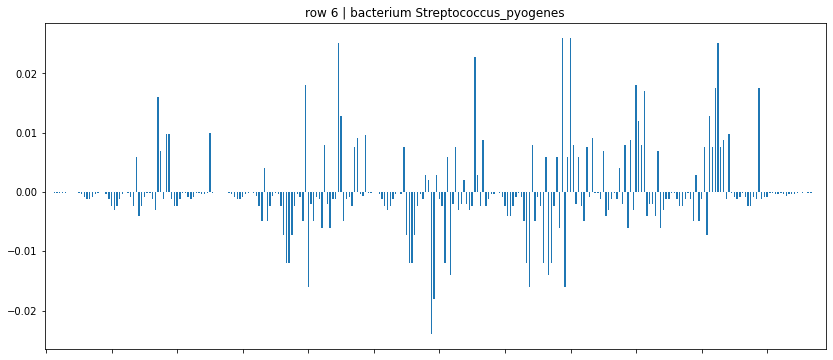

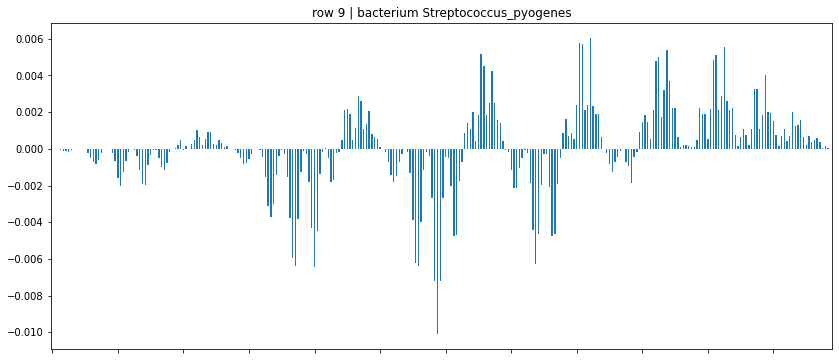

In [11]:
def plot_a_sample(case):
    fig = plt.figure(figsize=(14, 6))
    bacterium = train.set_index('row_id').iloc[case, -1]
    x = train.set_index('row_id').iloc[case, :-1]
    x.plot.bar()
    plt.xticks(np.arange(0, len(features), 24), "")
    plt.title(f"row {case} | bacterium {bacterium}")
    plt.show()
    
plot_a_sample(case=0)
plot_a_sample(case=6)
plot_a_sample(case=9)

The variability previosly highlighted depends on the fact that samples from the same bacterium are actullay quite different. Here we plotted three samples of Streptococcus Pyogenes and each one has spikes in different locations. Also the range of values changes and the way the values distributes around the spikes.

A good feature engineering probably has to take into accoutn also about these aspects by providing info about:

* peaks
* statistics
* distributions

## Feature engineering

The idea here is to represent measures such as:

* point-wise distribution descriptions (such as mean, specific quantiles)
* distribution measures
* measures of uncertainty relative to peaks

In [12]:
def feature_engineering(df):
    
    df['mean'] = df[features].mean(axis=1)
    df['median'] = df[features].median(axis=1)
    df['q01'] = df[features].quantile(q=0.01, axis=1)
    df['q05'] = df[features].quantile(q=0.05, axis=1)
    df['q10'] = df[features].quantile(q=0.10, axis=1)
    df['q25'] = df[features].quantile(q=0.25, axis=1)
    df['q75'] = df[features].quantile(q=0.75, axis=1)
    df['q90'] = df[features].quantile(q=0.90, axis=1)
    df['q95'] = df[features].quantile(q=0.95, axis=1)
    df['q99'] = df[features].quantile(q=0.99, axis=1)
    df['max'] = df[features].max(axis=1)
    df['min'] = df[features].min(axis=1)
    
    df['std'] = df[features].std(axis=1)
    df['range'] = df['max'] - df['min']
    df['iqr'] = df['q75'] - df['q25']
    df['tails'] = df['range'] / df['iqr']
    df['dispersion'] = df['std'] / df['mean']
    df['dispersion_2'] = df['iqr'] / df['median']
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurt(axis=1)
    
    df['median-max'] = df['median'] - df['max']
    df['median-min'] = df['median'] - df['min']
    df['q99-q95'] = df['q99'] - df['q95']
    df['q99-q90'] = df['q99'] - df['q90']
    df['q01-q05'] = df['q01'] - df['q05']
    df['q01-q10'] =  df['q01'] - df['q10']
    
    return df

feature_engineering(test)
feature_engineering(train)
original_features = features[:]
#features = [col for col in train.columns if col not in ['row_id', 'target']]

## Adding decamers

As explained in @AMBROSM's EDA there are different number of decamers in the sample due to the process described in the paper "Analysis of Identification Method for Bacterial Species and Antibiotic Resistance Genes Using Optical Data From DNA Oligomers" (https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full). We want to add also this feature to test if it is informative.

Please refer to this notebook https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense for the original code and upvote it if you find it useful,

In [13]:
def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(s):
    w = int(s[1:s.index('T')])
    x = int(s[s.index('T')+1:s.index('G')])
    y = int(s[s.index('G')+1:s.index('C')])
    z = int(s[s.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

train_i = pd.DataFrame({col: ((train[col] + bias_of(col)) * 1000000).round().astype(int) for col in original_features})
test_i = pd.DataFrame({col: ((test[col] + bias_of(col)) * 1000000).round().astype(int) for col in original_features})

def gcd_of_all(df_i, elements=original_features):
    gcd = df_i[elements[0]]
    for col in elements[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

train['gcd'] = gcd_of_all(train_i)
test['gcd'] = gcd_of_all(test_i)

features.append('gcd')

del([train_i, test_i])
gc.collect()

0

## Adversarial Validation

Before proceeding with the new features, let's check using adversarial validationif any of these causes overfitting. We achieve that by fitting a model trying to distinguish train from test. We evaluate on the fit using a cross-validation approach, averaging the results.

In [14]:
lr = ExtraTreesClassifier(n_estimators=100, n_jobs=-1)
Xt = train[features].append(test[features])
yt = [0 for _ in range(len(train))] + [1 for _ in range(len(test))]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_results = cross_validate(lr, Xt, yt, cv=cv, scoring='roc_auc', return_estimator=True, verbose=1)

del([Xt, yt])
gc.collect()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.4min finished


1377

In [15]:
roc = np.mean(cv_results['test_score'])
print(f"ROC_AUC score for adversarial validation {roc:0.5f}")

ROC_AUC score for adversarial validation 0.99392


In [16]:
feature_importances = np.mean([mod.feature_importances_ for mod in cv_results['estimator']], axis=0)

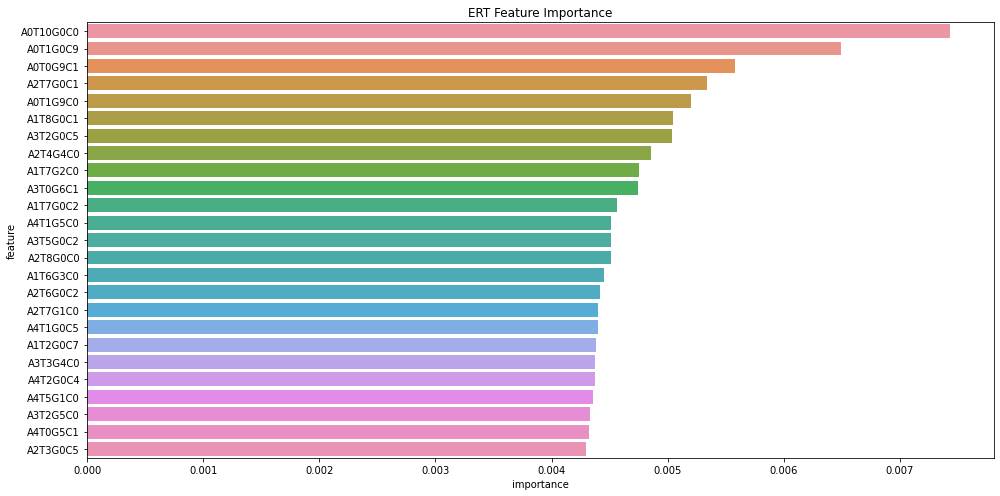

In [17]:
df_imp = pd.DataFrame({'feature': features, 'importance': feature_importances})

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", 
            data=df_imp.sort_values(by="importance", ascending=False).iloc[:25])
plt.title("ERT Feature Importance")
plt.tight_layout()

plt.show()

In [18]:
del(cv_results)
gc.collect()

7557

There seems to be some features that have characteristic values in the train set. We can use different options here, from recursively removing them in order to make the training more similar to the test to trying to use pseudo-labelling.

## Baseline modelling

Here is a first model taking into account the most frequent measurements of all the spectrum of histograms and some feature engineering.

In [19]:
FOLDS = 10
ESTIMATORS = 1_000

As we cross-validate, we store away, using joblib, the models for later ensembling a cv predict on the test set.

In [20]:
lb = LabelEncoder()

X = train[features]
y = lb.fit_transform(train['target'])

cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
test_score = list()

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    lr = ExtraTreesClassifier(n_estimators=ESTIMATORS, 
                              criterion='gini', 
                              max_features=128, 
                              min_samples_split=4, 
                              n_jobs=-1)
    lr.fit(X.iloc[train_idx], y[train_idx])
    cv_preds = lr.predict(X.iloc[val_idx])
    val_acc = accuracy_score(y_true=y[val_idx], y_pred=cv_preds)
    test_score.append(val_acc)
    print(f"fold {fold} - validation accuracy = {val_acc:0.5f}")
    joblib.dump(value=lr, filename=f'etr_models_fold_{fold}.gz', compress=9)
    gc.collect()
    
cv_accuracy = np.mean(test_score)
print(f"CV accuracy = {cv_accuracy:0.5f}")

fold 0 - validation accuracy = 0.99620
fold 1 - validation accuracy = 0.99620
fold 2 - validation accuracy = 0.99560
fold 3 - validation accuracy = 0.99715
fold 4 - validation accuracy = 0.99550
fold 5 - validation accuracy = 0.99715
fold 6 - validation accuracy = 0.99685
fold 7 - validation accuracy = 0.99565
fold 8 - validation accuracy = 0.99630
fold 9 - validation accuracy = 0.99725
CV accuracy = 0.99638


After training a random forest or an extremely randomized trees (ERT) classifier you can figure what features are important by looking at the splits in the forest. By summing up the impurity gain (how much that split helped in the classification) for each variable's splits you can get an idea of how much contribution a variable brings. Here we take the most importat features from the model trained on the last cv folds.

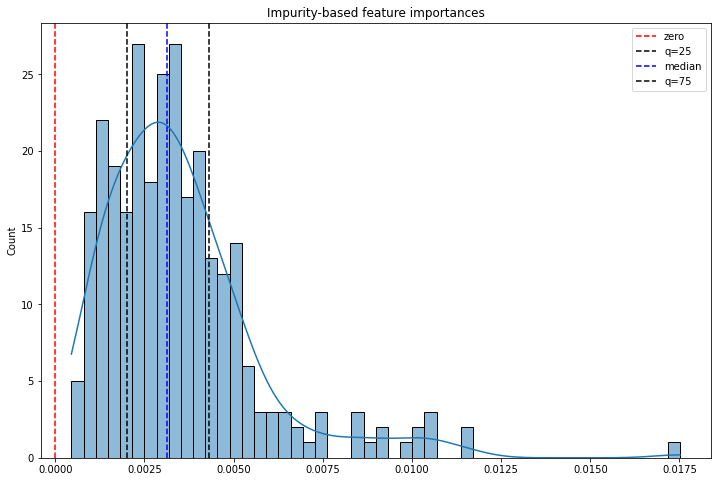

In [21]:
plt.figure(figsize=(12, 8))

sns.histplot(lr.feature_importances_, bins=50, kde=True)
plt.title("Impurity-based feature importances")

plt.axvline(x=0.0, color='red', linestyle='--', label="zero")
plt.axvline(x=np.percentile(lr.feature_importances_, q=25), color='black', linestyle='--', label="q=25")
plt.axvline(x=np.median(lr.feature_importances_), color='blue', linestyle='--', label="median")
plt.axvline(x=np.percentile(lr.feature_importances_, q=75), color='black', linestyle='--', label="q=75")

plt.legend()
plt.show()

The problem with ERT is that splits are randomly decided, therefore each feature has a possibility to be assigned some importance if it has some correlation with the target. That's the reason why you don't have any feature at zero importance. Anyway, from the 75th percentile you can see that there fewer and fewer features, pointing out that some features are indeed more important than others. 

Here are the top features pointed out:

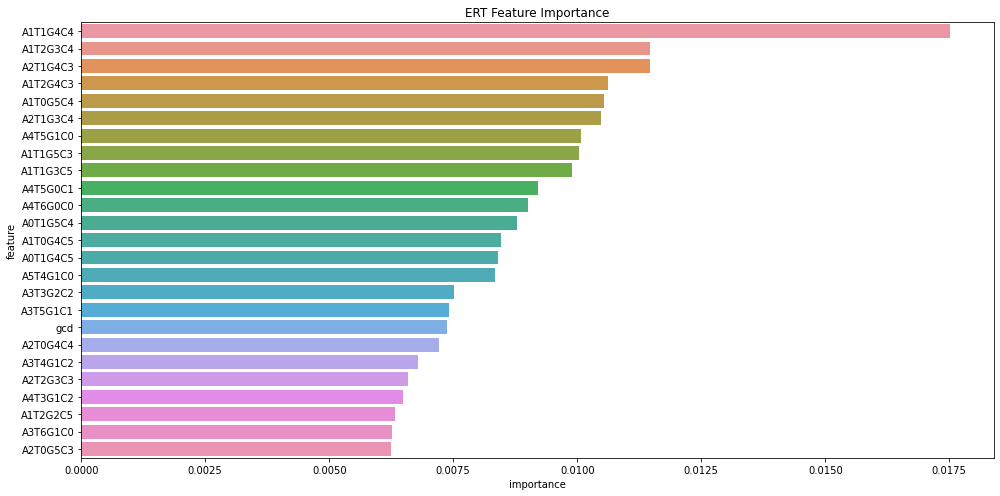

In [22]:
df_imp = pd.DataFrame({'feature': features, 'importance': lr.feature_importances_})

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", 
            data=df_imp.sort_values(by="importance", ascending=False).iloc[:25])
plt.title("ERT Feature Importance")
plt.tight_layout()

plt.show()

By taking the first 25 feature for importance, we notice that the ranges of the bases is in specifical ranges:

* A : 0-5
* T : 1-5
* G : 1-5
* C : 0-5

Probably higher bases count do contribute less. 

Let's now proceed to predict by retrieving all the ETR models we previously stored during cross-validation.

In [23]:
preds = [joblib.load(f'etr_models_fold_{fold}.gz').predict(test[features]) for fold in range(FOLDS)]

We find the most frequent class for each sample (using the mode function from Scipy), which equates to a voting ensemble.

In [24]:
from scipy import stats
most_frequent_pred = stats.mode(np.array(preds))[0][0]

We reconvert labels to the bacteria names and we store the test submission.

In [25]:
sub.target = lb.inverse_transform(most_frequent_pred)
sub.to_csv("submission.csv", index=False)

## If you found interesting this notebook, please consider to upvote :-)